In [188]:
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt

In [189]:
def column(matrix, i):
    return [row[i] for row in matrix]

def allPlayerSets(n, seq):
    set = []
    for p in itertools.product(seq, repeat=n):
        if sum(p) == 4:
            set.append(p)
    return set

In [190]:
class survivor:

    def __init__(self, player_name, player_strategy):
        """Defines Survivor strategy; selfless, selfish, selfless-leaning, selfish-leaning, and standard"""
        #self.survivor_num = num_survivors + 1
        self.player_name = player_name
        self.player_strategy = player_strategy

        self.is_injured = False #defines if you hav been injured
        self.gens_completed = 0
        self.score = 0
        self.hooks = 0
        self.r = .1

        if player_strategy == "STANDARD":
            self.help_p = .5 #probability to help
            self.STRATEGIES = {"Chased": [1/3, 1/3, 1/3], "Save": [1/2, 1/2], "Pop": [1/2, 1/2], "Help": [1/2, 1/2]}
        
        if player_strategy == "SELFLESS":
            self.help_p = 1 #probability to help
            self.STRATEGIES = {"Chased": [.1, .7, .2], "Save": [.95, 0.05], "Pop": [.8, .2], "Help": [1, 0]}

        if player_strategy == "SELFLESS-LEANING":
            self.help_p = .75 #probability to help
            self.STRATEGIES = {"Chased": [.2, .5, .3], "Save": [.7, .3], "Pop": [.6, .4], "Help": [.7, .3]}
        
        if player_strategy == "SELFISH":
            self.help_p = 0 #probability to help
            self.STRATEGIES = {"Chased": [.7, .1, .2], "Save": [0.05, .95], "Pop": [.2, .8], "Help": [0, 1]}

        if player_strategy == "SELFISH-LEANING":
            self.help_p = .25 #probability to help
            self.STRATEGIES = {"Chased": [.5, .2, .3], "Save": [.3, .7], "Pop": [.4, .6], "Help": [.3, .7]}
            
    def reset(self):
        self.is_injured = False 
        self.gens_completed = 0
        self.score = 0
        self.hooks = 0
        self.r = .1


    def strategicMove(self, situation):
        if situation == "Chased":
            return np.random.choice(["Run", "Obstacle", "Stun"],1, self.STRATEGIES["Chased"])[0]
        if situation == "Save":
            return np.random.choice(["Rescue", "Leave"],1, self.STRATEGIES["Save"])[0]
        if situation == "Pop":
            return np.random.choice(["Continue", "Leave"],1, self.STRATEGIES["Pop"])[0]
        if situation == "Help":
            return np.random.choice(["Heal", "Ignore"],1, self.STRATEGIES["Help"])[0]
        



    def request_help(self, game):
        """requests help from a particular survivor"""

        avail_players = game.free_survivors
        random.shuffle(avail_players)
        for survivor in avail_players:
            move = survivor.strategicMove("Help")
            if move == "Heal":
                self.is_injured == False
                survivor.score += 10
                return



    def pick_gen(self, avail_gens):
        choice = random.choice(avail_gens)
        return choice


    def nextMove(self, game):
        """Chooses whether to pick a generator to work on, or go and help a teammate"""

        if self.is_injured == True:
            self.request_help(game)
            if self.is_injured == False:
                return ("Hide", self)
        
        if all( (s==0 or s==1) for s in column(game.hook_set, 0)) !=True: # not empty
            help_decision = np.random.binomial(1, self.help_p)
            if help_decision == 1: #agrees to help
                #pick survivor to help
                hooked_survivors = [survivor for survivor in column(game.hook_set, 0) if survivor != 0 and survivor != 1]
                surv_choice = random.choice(hooked_survivors)
                return ("Hooked", [self, surv_choice])
        
        #pick generator
        if game.gens_fixed < 5:
            available_gens = [i for i in range(7) if 0 in game.gen_set[i]] # gives list of generators with available spot
            return ("Fix Gen", self, self.pick_gen(available_gens))
        else:# nothing left to do
            return ("Hide", self)

In [191]:
class killer:

    def __init__(self):
        """Defines Killer"""
        self.busy = False
        self.camp_p = .5

    def check_gen(self, gen_set):
        """"""
        choice = np.random.choice(range(len(gen_set)))
        return choice


    def nextMove(self, game):
        """takes in game opject"""
        gen_set = game.gen_set
        if self.busy == True:
            return ("Nothing", None)
        else:
            #check generator
            choice = self.check_gen(gen_set)
            picked_gen = gen_set[choice]
            found_survivors = [surv for surv in picked_gen if surv != 0 and surv != 1]
            if len(found_survivors) != 0:
                if len(found_survivors) == 1:
                    return ("Chase", found_survivors)
                else:
                    return ("Chase", found_survivors[:-1])

        avail_players = game.free_survivors
        random.shuffle(avail_players)
        for survivor in avail_players:
            search = np.random.binomial(1,survivor.r)
            if search == 1:
                return ("Chase", [survivor] )
        return ("Nothing", None)


In [192]:
class dbd:
    """Defines state of game"""
   
    def __init__(self, killer, survivors):
        self.gen_set = np.zeros((7,3), dtype=survivor) # 0 if not in use, 1 if fixed, player_object if being worked on
        self.gen_vals = np.zeros((7)) # 0 if not fixed, 3 if fixed
        self.hook_set = np.zeros((4,2), dtype=survivor) # 0 if not in use, 1 if used, player_object if hooked
        self.trap_door_open = False 

        self.num_rounds = 0
        self.players = [survivors[0], survivors[1], survivors[2], survivors[3]]
        self.free_survivors = survivors
        self.dead_survivors = []
        self.killer = killer

        self.survivors_alive = 4
        self.gens_fixed = 0
        self.canEscape = 2 # After all generators fixed, players must wait 2 rounds before being able to escape

#------------------------------------------------------------

    
    def __repr__(self):
        print("Round Number: " + self.num_rounds)
        print("Survivors Alive: " + self.survivors_alive)
        print("Generators Fixed: " + self.gens_fixed)

#------------------------------------------------------------

    def lookForTrapDoor(self, player):
        Found = np.random.binomial(1, 0.1)
        if Found:
            player.score += 50
        player.r = min(.9,player.r+.1)
        return (Found == 1)

#------------------------------------------------------------

    def fix_generator(self, player, choice):
        """accepts generator pick from survivor"""
        if player not in self.gen_set[choice]:
            pos = np.where(self.gen_set[choice] == 0)[0]
            if len(pos) == 0: return
            pos = pos[0]
            self.gen_set[choice][pos] = player

        
        workOnGenerator = True

        skillCheck = np.random.binomial(1, 0.5)
        if skillCheck:
            popGenerator = np.random.binomial(1, 1/3)
            if popGenerator:
                decision = player.strategicMove("Pop")
                workOnGenerator = (decision == "Continue")
                if workOnGenerator:
                    player.r = min(.9,player.r+.3)
                else:
                    pos = np.where(self.gen_set[choice] == player)
                    self.gen_set[choice][pos] = 0
                    return

        if workOnGenerator:
            self.gen_vals[choice] += 1

        if self.gen_vals[choice] == 5:
            self.gens_fixed += 1
            p=self.gen_set[choice,:]
            for i in range(len(p)):
                if p[i]!=0:
                    p[i].score+=10
                self.gen_set[choice][i] = 1

#------------------------------------------------------------

    def hooked(self, players):
        pos = np.where(self.hook_set[:,0] == players[1])[0][0]
        killerCamping =  all([self.hook_set[pos][1] != 0, self.hook_set[pos][1] != 1])
        
        decision = players[0].strategicMove("Save")
        if not killerCamping or decision == "Rescue":
            self.hook_set[pos][0] = 0
            self.free_survivors.append(players[1])
            players[0].score += 25
            players[0].r = min(.9, players[0].r + .3)
            
        else: return

        self.killer.busy = False
        self.hook_set[pos][1] = 0

        return self.chase(players)

#------------------------------------------------------------

    def chase(self, players):


        chasedPlayers = players 

        numChased = len(players)

        if numChased == 1:
            probs = {"Obstacle": 0.3, "Stun": 0.05, "Run": 0.2}
        else:
            probs_1 = {"Obstacle": 0.8, "Stun": 0.2, "Run": 0.5}
            probs_2 = {"Obstacle": 0.3, "Stun": 0.9, "Run": 0.5}
        
        
        turn = 0
        for chasedPlayer in chasedPlayers:
            
            
            if turn == 0 and numChased > 1:
                probs = probs_1
            if turn == 1 and numChased > 1:
                probs = probs_2
            
            while(True): 

                playerStrat = chasedPlayer.strategicMove("Chased")
                chaseOutcome = np.random.binomial(1, probs[playerStrat])

                if chaseOutcome == 1: # Escaped
                    chasedPlayer.score += 30
                    break
                else:  # Hit by killer
                    if not chasedPlayer.is_injured: # First hit -> continue chase
                        chasedPlayer.is_injured = True
                        chasedPlayer.r = min(.9, chasedPlayer.r+.3)
                    else: 
                        i = random.randint(0,3)
                        self.hook_set[i][0] = chasedPlayer                        
                        for p in self.free_survivors:
                            if p == chasedPlayer: self.free_survivors.remove(p)

                        chasedPlayer.hooks += 1
                        
                        if chasedPlayer.hooks == 3:
                            # KILL Player
                            self.dead_survivors.append(chasedPlayer)
                            self.hook_set[i][0] = 1
                            self.hook_set[i][1] = 1
                            self.survivors_alive -= 1
                        else:    
                            camping = np.random.binomial(1, self.killer.camp_p)
                            if camping: 
                                self.hook_set[i][1] = self.killer
                                self.killer.busy = True
            turn=1


#------------------------------------------------------------


    def run_round(self):
        ''' Runs a single round of the game'''

        workingOnGen = column(self.gen_set, 0) + column(self.gen_set, 1) + column(self.gen_set, 2)
        

        # Killers and free survivors take turns to play in a random order
        avail_players = self.free_survivors + [self.killer]
        random.shuffle(avail_players)
        for player in avail_players:
            
            if self.survivors_alive == 1 and player != self.killer:
                TrapDoorFound = self.lookForTrapDoor(player)
                if TrapDoorFound: return ("Trap Door Found!", [player])

            if player in workingOnGen:
                scenario = ("Fix Gen", player, workingOnGen.index(player) % 7)
            else:           
                scenario = player.nextMove(self)

            if scenario[0] == "Chase":
                self.chase(scenario[1])
            elif scenario[0] == "Hooked":
                self.hooked(scenario[1])
            elif scenario[0] == "Fix Gen":
                self.fix_generator(scenario[1], scenario[2])
            else:
                continue

        if self.gens_fixed == 5:
            doorOpen = (self.canEscape == 0)
            if doorOpen: return ("Escaped Door!", self.free_survivors)
            else: self.canEscape -= 1

        if self.survivors_alive == 0:
            return ("Game Over!", None)
        
        self.num_rounds += 1
        for survivor in self.free_survivors:
            survivor.r = max(0.1,survivor.r-.1)

        return None
            
#------------------------------------------------------------


    def play(self):
        ''' Runs rounds until game is over '''
        Outcome = None
        while Outcome == None:
            Outcome = self.run_round()
            if self.num_rounds == 100: 
                return None
        self.payoff(Outcome)
        return Outcome
            

#------------------------------------------------------------


    def payoff(self, Outcome):
        ''' Takes list of survivors alive and rewards everyone accordingly '''
        if Outcome[0] == "Game Over!":
            return
        else:
            winners = Outcome[1]
            numWinners = len(winners)

            for d in self.dead_survivors:
                d.score += 0.5 * d.score
            for w in winners:
                w.score += numWinners * w.score

In [260]:
# Available startegies
STRATEGIES = ["SELFLESS", "SELFISH", "SELFLESS-LEANING", "SELFISH-LEANING", "STANDARD"]

stratScores = {"SELFLESS":[], "SELFISH":[], "SELFLESS-LEANING":[], "SELFISH-LEANING":[], "STANDARD":[]}
stratNumEscapes = {"SELFLESS":0, "SELFISH":0, "SELFLESS-LEANING":0, "SELFISH-LEANING":0, "STANDARD":0}


# Defines how players for each strtagey we will have for a particular game
playerSET = allPlayerSets(5, [0,1,2,3, 4])
playerSET.append((1,1,1,1,1))
print(playerSET)


TotalGamesPlayed = 0
print("Begin Games")
for game_num in range(100):

    
    print("================================================")
    for playerDist in playerSET:

        
        # Initialize players
        ps = []
        playerNum = 1
        whosPlaying = "Players playing "
        for i in range(len(playerDist)):
            for j in range(playerDist[i]):
                playerName = "P" + str(playerNum)
                playerStrategy = STRATEGIES[i]
                ps.append(survivor(playerName, playerStrategy))
                playerNum += 1
                whosPlaying += playerName + ":" + playerStrategy + " "

        print(whosPlaying)

        K = killer()

        # Play 100 games of each player set
       # for game_num in range(1):

        # If all strategies playing (5), make one sit out each game 
        if len(ps) > 4:
            playerSittingOut = game_num % 5 
            survivorPlayers = [ps[i] for i in range(len(ps)) if i != playerSittingOut]
        else:
            survivorPlayers = [ps[0], ps[1], ps[2], ps[3]]

        # Create new game and play through till the end
        match = dbd(K, survivorPlayers)
        Outcome = match.play()

        # Game stuck in infinite loop for some reason
        if Outcome == None: continue

        # Find out who survived based on outcome and Update their escape values
        final = Outcome[0]
        if final == "Game Over!":
            final += " No survivors"
        else:
            for p in Outcome[1]:
                final += " " + p.player_name
                stratNumEscapes[p.player_strategy] += 1 # Update num escapes for strategy
            final += " Escaped!"

        print(final)

        # Save scores and reset all players
        for p in match.players:
            stratScores[p.player_strategy].append(p.score)
            p.reset()

        TotalGamesPlayed +=1
        print("----------------------------------------")


[(0, 0, 0, 0, 4), (0, 0, 0, 1, 3), (0, 0, 0, 2, 2), (0, 0, 0, 3, 1), (0, 0, 0, 4, 0), (0, 0, 1, 0, 3), (0, 0, 1, 1, 2), (0, 0, 1, 2, 1), (0, 0, 1, 3, 0), (0, 0, 2, 0, 2), (0, 0, 2, 1, 1), (0, 0, 2, 2, 0), (0, 0, 3, 0, 1), (0, 0, 3, 1, 0), (0, 0, 4, 0, 0), (0, 1, 0, 0, 3), (0, 1, 0, 1, 2), (0, 1, 0, 2, 1), (0, 1, 0, 3, 0), (0, 1, 1, 0, 2), (0, 1, 1, 1, 1), (0, 1, 1, 2, 0), (0, 1, 2, 0, 1), (0, 1, 2, 1, 0), (0, 1, 3, 0, 0), (0, 2, 0, 0, 2), (0, 2, 0, 1, 1), (0, 2, 0, 2, 0), (0, 2, 1, 0, 1), (0, 2, 1, 1, 0), (0, 2, 2, 0, 0), (0, 3, 0, 0, 1), (0, 3, 0, 1, 0), (0, 3, 1, 0, 0), (0, 4, 0, 0, 0), (1, 0, 0, 0, 3), (1, 0, 0, 1, 2), (1, 0, 0, 2, 1), (1, 0, 0, 3, 0), (1, 0, 1, 0, 2), (1, 0, 1, 1, 1), (1, 0, 1, 2, 0), (1, 0, 2, 0, 1), (1, 0, 2, 1, 0), (1, 0, 3, 0, 0), (1, 1, 0, 0, 2), (1, 1, 0, 1, 1), (1, 1, 0, 2, 0), (1, 1, 1, 0, 1), (1, 1, 1, 1, 0), (1, 1, 2, 0, 0), (1, 2, 0, 0, 1), (1, 2, 0, 1, 0), (1, 2, 1, 0, 0), (1, 3, 0, 0, 0), (2, 0, 0, 0, 2), (2, 0, 0, 1, 1), (2, 0, 0, 2, 0), (2, 0, 1, 0, 

Escaped Door! P1 P4 P3 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:STANDARD P3:STANDARD P4:STANDARD 
Players playing P1:SELFISH P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING 

Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door F

Escaped Door! Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P1 P4 P2 P4 P1 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 
Escaped Door! P3 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:STANDARD P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLES

Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 P2 P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped

Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:STANDARD P4:STANDARD 
Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P2 P1 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P1 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P4 P4 P2 Escaped!
----------------

Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:SELFLESS P3:STANDARD P4:STANDARD 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFL

Escaped Door! P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Players playing P1:SELFISH P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Esc

Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P3 P2 P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P

Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:STANDARD 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH-LEANING 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P1 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH 
Escaped Door! P1 P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:STANDARD 
Escaped Door!

Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P4 P3 P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P3 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P1 Escaped!
-----------------------------

Escaped Door! P4 P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P1 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P1 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:STANDARD P4:STANDARD 
Escaped Door! P1 P3 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P1 P2 Escaped!
-----

Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P4 P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped

Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P3 P2 P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:SELFLESS P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:STANDARD 
Escaped Door

Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH-LEANING 
Escaped Door! P4 P2 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS-LEANING 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Escaped Door! P3 P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P2 P5 P4 Escaped!
----------------------------------------
Players playing P1:STANDARD P2:STANDARD P3:STANDARD P4:STANDARD 
Players playing P1:SELFISH-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P3 P2 P1 Escaped!
----------------------------------

Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P2 P1 P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------

Players playing P1:SELFLESS P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P3 Escaped!
---------

Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFLESS-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH 
Escaped Door! P1 P2 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS-LEANING 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Escaped Door! P3 P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Trap Door Found! P2 Escaped!
---

Escaped Door! P3 P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SEL

Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
T

Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS-LEANING 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P2 P4 Escaped!
----------------------------------------
Players playing P1:STANDARD P2:STANDARD P3:STANDARD P4:STANDARD 
Players playing P1:SELFISH-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SE

Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P2 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:STANDARD 
Escaped Door! P1 P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P3 P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:STANDARD P3:STANDARD P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Players playing

Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFLESS-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:STANDARD 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH-LEANING 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Players playing P1:SELFLESS P2:SELFISH P3

Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P1 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P1 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEAN

Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:STANDARD 
Escaped Door! P2 P1 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P4 P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P3 P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Players

Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:STANDARD P4:STANDARD 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:

Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P1 P3 P2 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:

Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P2 P4 P1 P1 Escaped!
----------------------------------------
Players playin

Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:S

Escaped Door! P1 P3 P4 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P3 P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P1 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELF

Escaped Door! P2 P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:STANDARD P4:STANDARD 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFISH P2:SELFI

Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:STANDARD P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P1 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 
Escaped Door! P4 P3 P2 Escaped!
----------------------------------------
Pl

Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! Escaped!
----------------------------------------
Players playing P1:SELFISH P2:

Escaped Door! P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Players playing P1:SELFLESS P2:SELFISH P3:STANDARD P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Playe

Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH-LEANING 
Escaped Door! P1 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P5 P2 P3 Escaped!
----------------------------------------
Players playin

Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P3 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P1 P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:STANDARD 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P1 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH 
Escaped Door! P4 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:STANDARD P3:STANDARD P4:STANDARD 
Game Over! No

Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH-LEANING 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS-LEANING 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P4 P2 P3 P5 Escaped!
----------------------------------------
Players playing P1:

Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:STANDARD P4:STANDARD 
Escaped Door! P1 P4 P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH 

Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P1 P2 P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:SELFLESS P3:STANDARD P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SEL

Escaped Door! P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P1 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 P1 Escaped!
----------------------------------------
P

Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P1 P4 P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Players playing P1:SELFLESS P2:SELFISH P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 


Players playing P1:SELFLESS-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELF

Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:STANDARD P4:STANDARD 
Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P4 P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 


Escaped Door! P2 P4 Escaped!
----------------------------------------
Players playing P1:STANDARD P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P2 P1 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-L

Players playing P1:SELFLESS P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P

Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P5 Escaped!
----------------------------------------
Players playing P1:STANDARD P2:STANDARD P3:STANDARD P4:STANDARD 
Players playing P1:SELFISH-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS-LEANING P2:STANDAR

Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:STANDARD 
Escaped Door! P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P1 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P1 Escap

Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P2 P5 P4 Escaped!
----------------------------------------
Players playing P1:STANDARD P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P3 P2 P1 Escaped!
-----------------------

Escaped Door! P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P4 P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:STANDARD 
Escaped Door! P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:STANDARD P3:STANDARD P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFL

Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:STANDARD 
Escaped Door! P4 P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH 
Trap Door Found! P3 Escaped!
----------------------------------------
Playe

Players playing P1:SELFISH P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P1 P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P1 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P3 P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Players playing P

Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANI

Escaped Door! P3 P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELF

Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P3 P4 P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:STANDARD 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P1 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P1 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P2 P4 Escaped!
----------------------------------------
Players playi

Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 P2 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANI

Escaped Door! P3 P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:SELFLESS P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P1 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P4 Escaped!
--------------------------------

Escaped Door! P3 P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P2 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH 
Escaped Door! P3 P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:STANDARD P4:STANDARD 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P1 P4 Escaped!
----------------------------------------
Players play

Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFLESS-LE

Escaped Door! P1 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P1 P4 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P1 P2 P3 P4 Escaped!
--------------------------------

Escaped Door! P1 P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:STANDARD P4:STANDARD 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P1 Escaped!
-------------

Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLE

Escaped Door! P1 P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:STANDARD 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFLESS-LEANING 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH 
Escaped Door! P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:STANDARD 
Escaped Door! Esc

Escaped Door! P1 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLE

Escaped Door! P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:STANDARD 
Escaped Door! P3 P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P1 P3 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P1 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH 
E

Escaped Door! P2 P4 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 


Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS-LEANING 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:STANDARD P2:STANDARD P3:STANDARD P4:STANDARD 
Players playing P1:SELFISH-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P4 P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Game Over! No survivors
----------------------------------------
P

Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P2 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P4 P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS-LEANING P2:SELFLESS-LEANING P3:STAND

Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P1 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P1 P2 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
E

Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P3 P2 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Escaped Door! P3 P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH 
Escaped Door! P2 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:STANDARD P4:STANDARD 
Escaped Door! P3 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:

Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:STANDARD P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P1 P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P1 P2 P3 Escaped!
------------------------------------

Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P3 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Trap D

Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Players playing P1:SELFISH P2:SELFISH P3:SELFISH P4:SELFISH 
Escaped Door! P1 P4 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P1 P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P3 P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Playe

Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFLESS-LEANING 
Escaped Door! P1 P2 P4 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:STANDARD 
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH-LEANING 
Escaped Door! P2 P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFLESS-LEANING 
Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFISH P3:SELFISH P4:SELFISH 
Players playing P1:SELFLESS P2:SELFLESS P3:STANDARD P4:STANDARD 
Players playing

Escaped Door! P3 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFISH P4:SELFISH 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:STANDARD 
Escaped Door! P1 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS-LEANING 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFISH 
Escaped Door! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P2 P4 Escaped!
----------------------------------------
Players playing P1:STANDARD P

Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFLESS P2:SELFLESS P3:SELFLESS P4:SELFLESS 
Players playing P1:SELFLESS P2:SELFISH P3:SELFLESS-LEANING P4:SELFISH-LEANING P5:STANDARD 
Escaped Door! P2 P4 Escaped!
----------------------------------------
Players playing P1:STANDARD P2:STANDARD P3:STANDARD P4:STANDARD 
Escaped Door! P3 P1 P4 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:STANDARD P3:STANDARD P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Game Over! No survivors
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Escaped Door! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH-LEANING P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Trap Door Found! P2 Escaped!
-----

Trap Door Found! P2 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:STANDARD P4:STANDARD 
Escaped Door! P2 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFISH-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Escaped Door! P2 P4 P1 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:STANDARD P4:STANDARD 
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:STANDARD 
Trap Door Found! P3 Escaped!
----------------------------------------
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFISH-LEANING P4:SELFISH-LEANING 
Players playing P1:SELFISH P2:SELFLESS-LEANING P3:SELFLESS-LEANING P4:STANDARD 
Trap Door Found! P4 Escaped!
----------------------------------------
Players playing P1:SELFISH

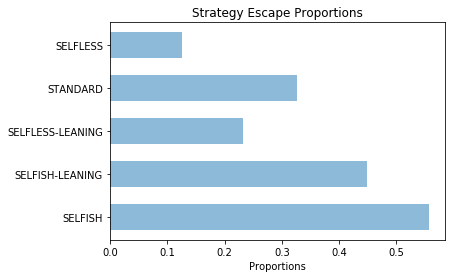

In [261]:
strats = list(stratNumEscapes.keys())
props = list(stratNumEscapes.values()) 
props = [val / TotalGamesPlayed for val in props]

plt.barh(strats, props, height = 0.6, align='center', alpha=0.5)
plt.xlabel('Proportions')
plt.title('Strategy Escape Proportions')
plt.show()


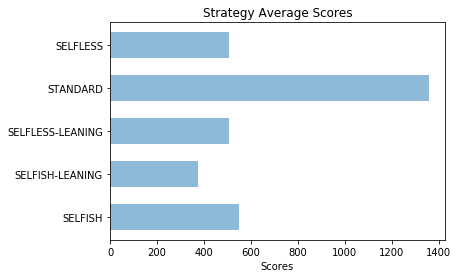

In [262]:
strats = list(stratScores.keys())
scores = list(stratScores.values())
avgScores = [sum(s)/len(s) for s in scores]

plt.barh(strats, avgScores, height = 0.6, align='center', alpha=0.5)
plt.xlabel('Scores')
plt.title('Strategy Average Scores')
plt.show()


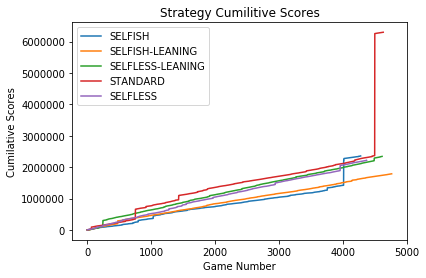

In [263]:
strats = list(stratScores.keys())
scores = list(stratScores.values())
cumScores = [[sum(ls[:i]) for i in range(len(ls))] for ls in scores]

plt.plot(cumScores[0], label=strats[0])
plt.plot(cumScores[1], label=strats[1])
plt.plot(cumScores[2], label=strats[2])
plt.plot(cumScores[3], label=strats[3])
plt.plot(cumScores[4], label=strats[4])
plt.title("Strategy Cumilitive Scores")
plt.xlabel("Game Number")
plt.ylabel("Cumilative Scores")
plt.legend()
plt.show()